## Loading modules and the dataset

In [2]:
# Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import xgboost

In [3]:
# Dataset
original_df = pd.read_csv("data/train.csv", delimiter=",")

## Exploring the dataset
### Basics information

In [4]:
# Basic information (shape, ...)
print(f"Dataset shape : {original_df.shape}")
print(f"Number features : {original_df.shape[1]}")
print(f"Number sample : {original_df.shape[0]}")
original_df.info()

Dataset shape : (225000, 325)
Number features : 325
Number sample : 225000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225000 entries, 0 to 224999
Columns: 325 entries, _STATE to TARGET
dtypes: bool(1), float64(318), int64(6)
memory usage: 556.4 MB


In [5]:
# Showing a bit of the dataset
original_df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,ID,TARGET
0,2.0,5.0,5132022,5,13,2022,1100.0,2022000436,2.022000e+09,1.0,...,1.0,2.700000e+01,1.0,1.870000e+02,1.0,1.0,1.0,2.0,0,True
1,9.0,1.0,2282022,2,28,2022,1200.0,2022005381,2.022005e+09,NaN,...,9.0,9.000000e+02,9.0,9.990000e+04,9.0,NaN,NaN,NaN,1,False
2,19.0,1.0,1202022,1,20,2022,1100.0,2022000927,2.022001e+09,1.0,...,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,9.0,2,False
3,39.0,8.0,8122022,8,12,2022,1100.0,2022014408,2.022014e+09,NaN,...,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0,3,False
4,25.0,7.0,7222022,7,22,2022,1200.0,2022010910,2.022011e+09,NaN,...,1.0,1.700000e+01,2.0,4.670000e+02,1.0,NaN,NaN,2.0,4,False


In [6]:
# Pourcentage de valeurs manquantes par colonne
missing_percent = original_df.isna().mean() * 100

# Affichage propre, trié du plus manquant au moins manquant
missing_percent = missing_percent.sort_values(ascending=False)

print(missing_percent)

TOLDCFS     100.000000
HAVECFS     100.000000
WORKCFS     100.000000
COLGHOUS     99.994222
COLGSEX1     99.993778
               ...    
_TOTINDA      0.000000
_HCVU652      0.000000
_HLTHPLN      0.000000
_MENT14D      0.000000
TARGET        0.000000
Length: 325, dtype: float64


In [ ]:
# Calcul du pourcentage de valeurs manquantes par feature
missing_pct = original_df.isna().mean() * 100

# Définition des tranches (bins) de 0 à 100 par pas de 10
bins = np.arange(0, 101, 1)  # 0,10,20,...,100
labels = [f"{i}-{i+1}%" for i in range(0, 100, 1)]

# Catégorisation des features selon leur tranche de % de manquants
categories = pd.cut(missing_pct, bins=bins, labels=labels, right=False, include_lowest=True)

# Comptage du nombre de features dans chaque tranche
summary = categories.value_counts().sort_index()

# Transformation en DataFrame pour un rendu propre
missing_tranches_df = pd.DataFrame({
    'Tranche_%_manquants': summary.index,
    'Nb_features': summary.values
})

print(missing_tranches_df)

#Faire un histogramme 


   Tranche_%_manquants  Nb_features
0                 0-1%           85
1                 1-2%            1
2                 2-3%            2
3                 3-4%            2
4                 4-5%            3
..                 ...          ...
95              95-96%            5
96              96-97%            3
97              97-98%           34
98              98-99%           19
99             99-100%           13

[100 rows x 2 columns]


➡️ Colonnes conservées : 197 / 325


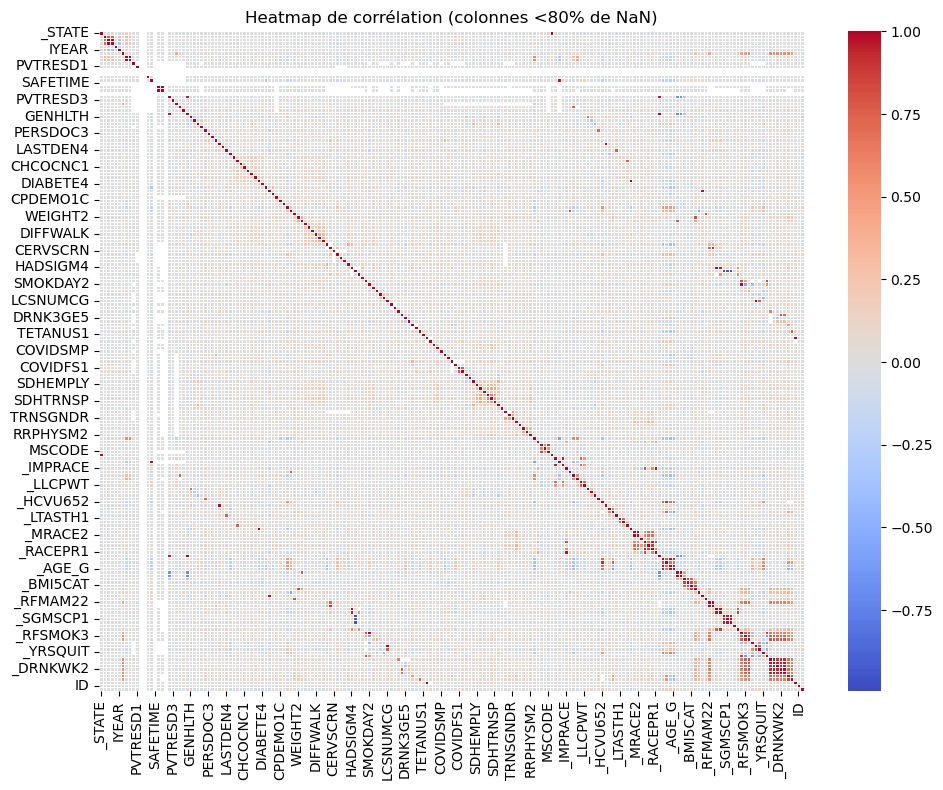

In [25]:
# Calcul du pourcentage de valeurs manquantes
missing_pct = original_df.isna().mean() * 100

# Suppression des colonnes avec plus de 80 % de valeurs manquantes
filtered_df = original_df.loc[:, missing_pct < 80]
print(f"➡️ Colonnes conservées : {filtered_df.shape[1]} / {original_df.shape[1]}")

# Calcul de la matrice de corrélation (uniquement numérique)
corr_matrix = filtered_df.corr(numeric_only=True)

# Création du heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,       # mets True si tu veux afficher les valeurs
    linewidths=0.5
)
plt.title("Heatmap de corrélation (colonnes <80% de NaN)")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# 1) Config
target_col = original_df.columns[-1]
print(f"🎯 Nom de la colonne Target : {target_col}")

# 2) % de valeurs manquantes (sur toutes les colonnes)
missing_pct = original_df.isna().mean() * 100

# 3) Conversion en numérique pour calculer la corrélation (Pearson)
#    - les colonnes non numériques deviennent NaN
df_num = original_df.apply(pd.to_numeric, errors='coerce')

# 4) Corrélation avec la Target (si convertible et au moins 2 valeurs non-NaN)
if target_col in df_num.columns and df_num[target_col].notna().sum() >= 2:
    corr_series = df_num.corr(numeric_only=True)[target_col]
else:
    corr_series = pd.Series(index=df_num.columns, dtype=float)

# 5) Tableau récapitulatif
summary = pd.DataFrame({
    'feature': original_df.columns,
    '%missing': missing_pct.reindex(original_df.columns).values,
    'corr_with_Target': corr_series.reindex(original_df.columns).values
})

# Option : retirer la ligne Target elle-même
summary = summary[summary['feature'] != target_col]

# 6) Tri : moins de valeurs manquantes d'abord, puis |corr| décroissante
summary = summary.sort_values(
    by=['%missing', 'corr_with_Target'],
    ascending=[True, False],
    key=lambda s: (np.abs(s) if s.name == 'corr_with_Target' else s)
).reset_index(drop=True)

print(summary)

# 7) Export CSV (optionnel)
summary.to_csv("features_missing_corr_target.csv", index=False)
print("✅ Exporté: features_missing_corr_target.csv")


🎯 Nom de la colonne Target : TARGET
      feature    %missing  corr_with_Target
0      _AGE80    0.000000          0.231371
1    _AGEG5YR    0.000000          0.222521
2      _AGE_G    0.000000          0.214506
3    _HCVU652    0.000000          0.194126
4    _AGE65YR    0.000000          0.184403
..        ...         ...               ...
319  COLGSEX1   99.993778          0.206725
320  COLGHOUS   99.994222               NaN
321   TOLDCFS  100.000000               NaN
322   HAVECFS  100.000000               NaN
323   WORKCFS  100.000000               NaN

[324 rows x 3 columns]
✅ Exporté: features_missing_corr_target.csv


In [27]:

# Filtrer uniquement les features avec |corr| > 0.1
filtered_summary = summary[summary['corr_with_Target'].abs() > 0.1]

# Trier par corrélation décroissante
filtered_summary = filtered_summary.sort_values(by='corr_with_Target', ascending=False).reset_index(drop=True)

# Afficher le résultat
print("✅ Features avec |corr(Target)| > 0.1 :")
print(filtered_summary)

✅ Features avec |corr(Target)| > 0.1 :
     feature   %missing  corr_with_Target
0     _AGE80   0.000000          0.231371
1   _AGEG5YR   0.000000          0.222521
2    GENHLTH   0.000444          0.222041
3     _AGE_G   0.000000          0.214506
4   COLGSEX1  99.993778          0.206725
5    EMPLOY1   1.439111          0.203364
6   _HCVU652   0.000000          0.194126
7   _AGE65YR   0.000000          0.184403
8   _PACKYRS  67.582667          0.168462
9   _YRSSMOK  66.520444          0.161509
10   _RFHLTH   0.000000          0.152469
11  _PACKDAY  65.851111          0.121894
12  CRVCLCNC  69.981778          0.105677
13  CHILDREN   2.155556          0.105020
14    QSTVER   0.000000         -0.101399
15  _SMOKGRP   8.182222         -0.115289
16  HAVARTH4   0.000444         -0.126937
17  DIFFWALK   5.084444         -0.129064
18  RMVTETH4   0.450667         -0.129525
19  RESPSLCT  88.496889         -0.139966
20  COPDBRTH  97.591111         -0.146857
21  DIABETE4   0.000444         -0.15

/var/folders/d_/t9ldkcd929v748ntq0jvc4tr0000gn/T/ipykernel_8312/3279121741.py:20: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/envs/SDD_supaero_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


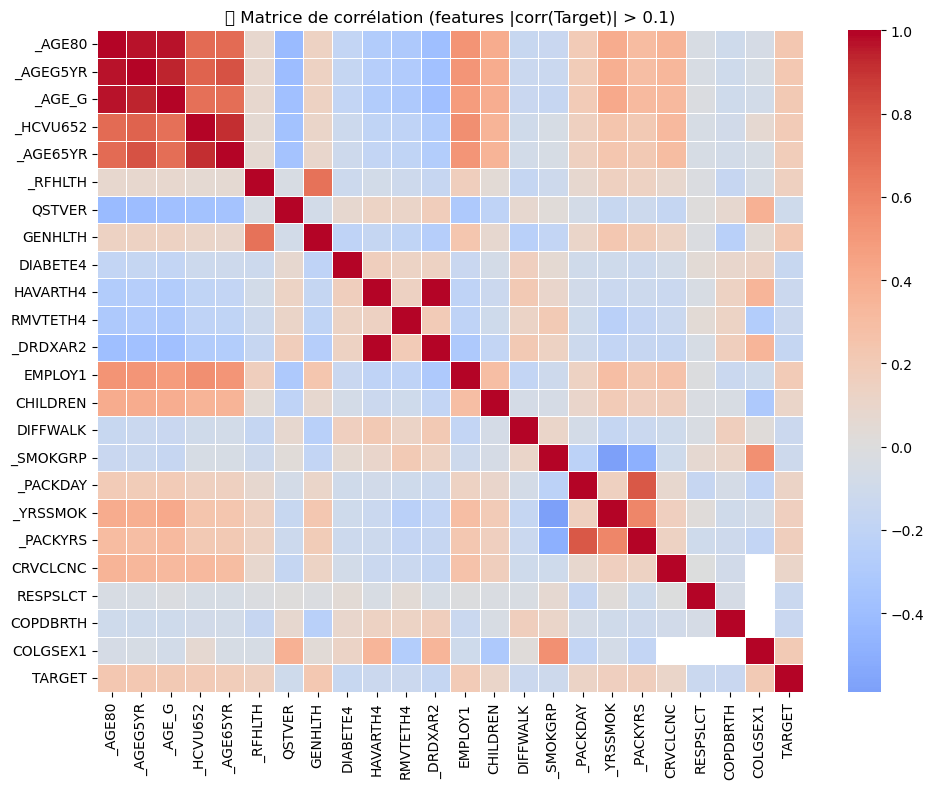

In [29]:
# 6️⃣ Filtrer les features avec |corr| > 0.1
selected_features = summary.loc[summary['corr_with_Target'].abs() > 0.1, 'feature'].tolist()

# 7️⃣ Créer un sous-DataFrame avec ces features + la Target
filtered_df = df_num[selected_features + [target_col]]

# 8️⃣ Calcul de la matrice de corrélation filtrée
corr_matrix_filtered = filtered_df.corr(numeric_only=True)

# 9️⃣ Affichage du heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix_filtered,
    cmap='coolwarm',
    center=0,
    annot=False,
    linewidths=0.5
)
plt.title("🔗 Matrice de corrélation (features |corr(Target)| > 0.1)")
plt.tight_layout()
plt.show()